<a href="https://colab.research.google.com/github/lorenzo-crippa/3M_NLP_ESS_2022/blob/main/Tutorial_Ten_(Python)_Transfer_Learning_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with BERT and other Pre-Trained Language Models

## Douglas Rice

*This tutorial was originally created by Burt Monroe and Sam Bestvater for their prior work with the Essex Summer School. I've updated and modified it.*

In this notebook, we'll explore how to leverage pre-trained contextualized embeddings for your own classification tasks. After completing this notebook, you should be familar with:


1. BERT & DistilBERT
2. AutoTokenizer
3. AutoModel


We will consider two such models, Google's BERT base uncased (Devlin et al. 2018) and Hugging Face's DistilBERT (Sanh et al. 2019). Along the way, we will also encounter the Hugging Face `transformers` package for Python, which is quickly becoming one of the essential tools for NLP transfer learning in Python.


## Setup Environment

As always, we need to get the environment set up. Most everything here is what we've seen before, but we are updating this to now includes the `transformers` module.

In [1]:
!pip install tensorflow==2.5.0
!pip install -U tensorflow-text==2.5.0
!pip install transformers==4.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 454.3 MB 18 kB/s 
     |████████████████████████████████| 132 kB 65.7 MB/s 
     |████████████████████████████████| 1.2 MB 44.1 MB/s 
     |████████████████████████████████| 4.0 MB 55.0 MB/s 
     |████████████████████████████████| 462 kB 60.4 MB/s 
     |████████████████████████████████| 14.8 MB 47.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=82ae24398a9dd4d0c1a81241ebd6661192d6ea3e71ac93588f4f2c0a23114a2a
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 26.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 12.3 MB/s 
     |████████████████████████████████| 880 kB 28.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=63f91872e5cb53317d35f67d02c863b594e8cc73a6e0510d00387743f4a17a97
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


Let's import all of these now that they are installed. We'll also import some of the other functionality that we've been making use of along the way. 

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


The last part of that is there to make sure that Colab is running as a GPU. With transformer models, the training or updating of these could take an enormous amount of time given what we are going to see are really huge numbers of trainable parameters.

## Import the Data

Now let's load our IMDB movie reviews dataset. We've encountered a number of different ways to load this particular dataset (including loading it directly from Keras, already in a TensorFlow-compatible format). For this demo, we're going to load the data from a CSV file, as that more closely represents common practices for social science applications.

In [3]:
# Load dataset from URL
imdb = pd.read_csv("https://github.com/bestvater/misc/raw/master/IMDB%20Dataset.csv")


In [5]:
print(imdb["sentiment"]) # positive and negative. We want to turn them to 0 and 1

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object


In [6]:
imdb['sentiment'].replace(to_replace = {'positive':1, 'negative':0}, inplace = True)
imdb = imdb.sample(frac = 1, random_state=101).reset_index(drop = True)

#determine train-test-val split
splits = ['train']*15000
splits.extend(['test']*25000)
splits.extend(['val']*10000)
imdb['split'] = splits

imdb = imdb.sample(frac = 1, random_state=42).reset_index(drop = True)


# Split dataset into pre-specified training, validation, and test sets 

train = imdb[['review', 'sentiment']][imdb['split']=='train'].reset_index(drop = True)
test = imdb[['review', 'sentiment']][imdb['split']=='test'].reset_index(drop = True)
val = imdb[['review', 'sentiment']][imdb['split']=='val'].reset_index(drop = True)

print(train.shape)
print(test.shape)
print(val.shape)

(15000, 2)
(25000, 2)
(10000, 2)


Now we will get our first introduction to the `transformers` package. We're going to load in two functions, `AutoTokenizer` and `TFAutoModelFromSequenceClassification`. Let's load them first and then talk about what they do.

In [7]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

## AutoTokenizer for BERT Tokenization

We already know that a neural network can't read raw texts as inputs--those texts need to be tokenized before they can be understood.

When we're working with a neural network built from scratch, there's a lot of flexibility in how we tokenize--we could use counts of words, one-hot representations of words, dense embeddings, character-level representations, etc. We can set the vocabulary size, or embedding dimension to whatever we wish.

When we're working with a pre-trained model, we don't have that kind of flexibility. The model expects to see inputs in the specific format that matches the inputs it was initially trained on. The easiest way to ensure that new inputs match that format is to use the same tokenizer as the model used during pre-training. Repositories like Hugging Face know this, so they provide approprate tokenizers alongside the pre-trained models they host. 

The `AutoTokenizer.from_pretrained()` method takes a valid pretrained model name from the Hugging Face repository as an argument, and returns the tokenizer appropriate to that model.

BERT's tokenizer uses a variation of word-piece tokenization, and truncates input sequences to 512 tokens, so that's the maxium length available for input documents with BERT. However, you can use the `model_max_length` argument to specify a shorter length if desired. Here I use 256-token inputs, as the network can process the shorter documents faster.

In [8]:
model_name = 'bert-base-uncased'
BERT_tokenizer = AutoTokenizer.from_pretrained(model_name, # autotokenizer is HF's python function for taking the right tokenizer
                                               model_max_length = 256) # by default, BERT takes inputs up to 512, but that will take a very long time to train

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Now that we have the tokenizer, we'll apply it to the training, test, and validation documents. the `padding` argument tells the tokenizer to pad out documents less than the model's max length, which in this case we set to 256, and the `truncation` argument tells it to cut off documents longer than 256. The `return_tensors` argument tells it what format to use when returning the tokenized texts--'tf' for TensorFlow, 'pt' for Pytorch.

In [9]:
X_train = BERT_tokenizer(list(train['review']), padding='max_length', truncation=True, return_tensors='tf')
X_test = BERT_tokenizer(list(test['review']), padding='max_length', truncation=True, return_tensors='tf')
X_val = BERT_tokenizer(list(val['review']),padding='max_length', truncation=True, return_tensors='tf')

y_train = tf.convert_to_tensor(train['sentiment'])
y_test = tf.convert_to_tensor(test['sentiment'])
y_val = tf.convert_to_tensor(val['sentiment'])

# both Xs and ys have been: tokenized and turned into tensors. So we can feed them to BERT

## AutoModel to Set Up BERT

Now that we have a tokenizer sorted, let's actually download our pre-trained BERT model. For this, we'll use another `transformers` function: `TFAutoModelForSequenceClassification`. The 'TF' is for TensorFlow, to distinguish from Pytorch models, which exist in the same repository. 'AutoModel' means it's going to take the model name as an input, like with the `AutoTokenizer`, and determine what we're looking for without us having to specify, and the 'ForSequenceClassification' tells the library what "head," or output layer, we want on the model. 

Once downloaded, we can look at the model summary the same way we would if we built the architecture in Keras ourselves.

In [10]:
# download pretrained model as TF, specify that there is one label in output layer
BERT_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 1) 

BERT_model.summary()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


Yeah, that's a lot of trainable parameters...

Next we compile the model, like we would with any other Keras model. The only thing different here is that rather than just specifying that we're using the adam optimizer, we are going to specify a smaller learning rate for it to use as its base learning rate, since Transformers tend to work best with lower learning rates. (Conventional wisdom I've picked up--I'm not entirely sure why that is. Perhaps due to the extreme complexity of the parameter space?)

In [11]:
BERT_model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), #still adam optimizer, but we want to specify a small initial learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Now we can fit the model. 

A couple things to note here: first, our input texts are made into a dictionary of tensors using the `dict()` command. Why do they need to be a dictionary of tensors? Because that's the format expected by the pretrained model. This is of little theoretical interest, but illustrates a practical point: while tools like `Keras` and `Transformers` have done a lot to standardize how transfer learning works in NLP, it's not perfect yet, and often to get a model running you'll need to read its documentation on the Hugging Face website to identify ideosycratic requirements like this one.

Next, note that we've set quite a small batch size. While there are reasons why you would pick a smaller batch size over a larger one that relate to the rate at which the model updates its parameters, that's not why we did it--it's because if we go much bigger the batch won't fit in the GPU's memory and the runtime will crash. If you are working with more powerful compute resources, you might be able to increase this a bit.

Finally, since the model is so complex, and the batch size is so small, we'll only train for 2 epochs so that it runs in a reasonable amount of time.

In [12]:
history = BERT_model.fit(dict(X_train), y_train, 
                         validation_data=(dict(X_val), y_val), 
                         epochs = 2, 
                         batch_size = 16) 
# notice: we set 2 epochs and small batch size to make it tractable, but 
# you most likely would like to have longer epochs and larger batch sizes

# don't worry about all the warning messages--the Transformers package is extremely verbose on TensorFlow for some reason.

Epoch 1/2


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


938/938 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8633

938/938 [==============================] - 1103s 1s/step - loss: 0.3049 - accuracy: 0.8633 - val_loss: 0.2513 - val_accuracy: 0.8896
Epoch 2/2
938/938 [==============================] - 1039s 1s/step - loss: 0.1583 - accuracy: 0.9404 - val_loss: 0.2802 - val_accuracy: 0.8965


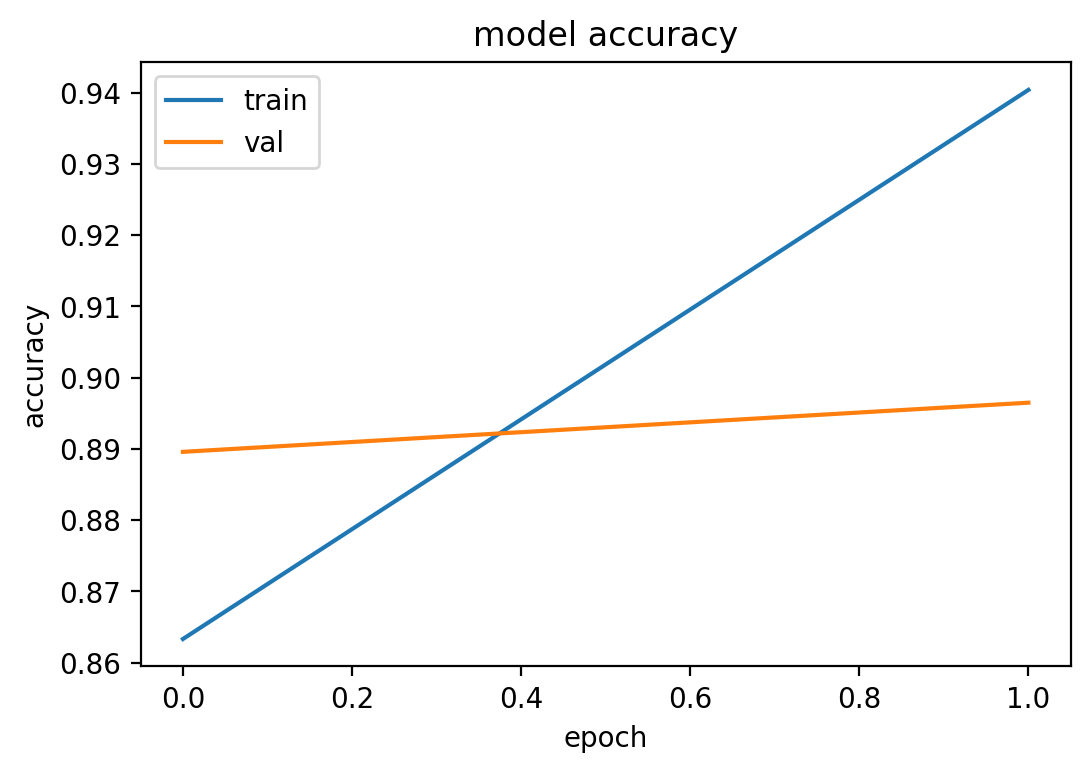

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

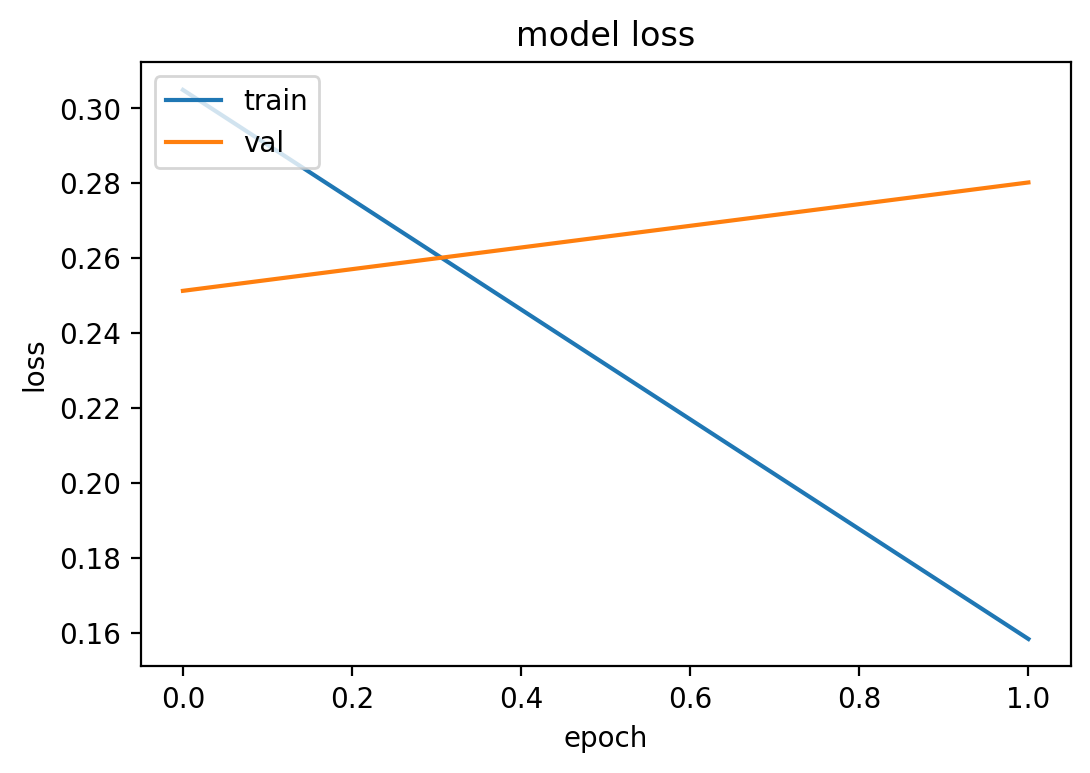

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
BERT_model.evaluate(dict(X_test), y_test, batch_size=100) # we can set a larger batch size here to get through the test data faster

250/250 [==============================] - 482s 2s/step - loss: 0.2698 - accuracy: 0.8972


[0.2697692811489105, 0.8972399830818176]

That's the best result we've seen on this classification problem, at ~90% accuracy. However, that fine-tuning process took over 10 minutes per epoch to run. Even BERT-base is a really big model with a lot of parameters to update.

## Let's try this with DistilBERT

DistilBERT is another pretrained model available on the Hugging Face repository. It uses "distillation" to reduce the number of parameters of the pretrained BERT-base model while maintaining most of its performance. 

We can use `AutoTokenizer` again to get the DistilBERT tokenizer, but this time let's set the max sequence length to 512, since the model itself is more lightweight and should train faster.



In [ ]:
model_name = 'distilbert-base-uncased'
DBERT_tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length = 512) 

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
X_train = DBERT_tokenizer(list(train['review']), padding='max_length', truncation=True, return_tensors='tf')
X_test = DBERT_tokenizer(list(test['review']), padding='max_length', truncation=True, return_tensors='tf')
X_val = DBERT_tokenizer(list(val['review']),padding='max_length', truncation=True, return_tensors='tf')

y_train = tf.convert_to_tensor(train['sentiment'])
y_test = tf.convert_to_tensor(test['sentiment'])
y_val = tf.convert_to_tensor(val['sentiment'])

Now we can load the pretrained DistilBERT model, same as before.

We can see it's got about 60% of the trainable parameters of the standard BERT model (though ~67 million parameters is still a lot...)

The architecture is also a little different from BERT's, there's an extra dense layer after the pretrained DistilBERT layers.

In [ ]:
DBERT_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 1)

DBERT_model.summary()

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  769       
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,954,241
Trainable params: 66,954,241
Non-trainable params: 0
_________________________________________________________________


Compile and fit the same way as before. Note that the fit took ~35 minutes on a recent run.

In [ ]:
DBERT_model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), #still adam optimizer, but we want to specify a small initial learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = DBERT_model.fit(dict(X_train), y_train, 
                         validation_data=(dict(X_val), y_val), 
                         epochs = 2, 
                         batch_size = 16) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

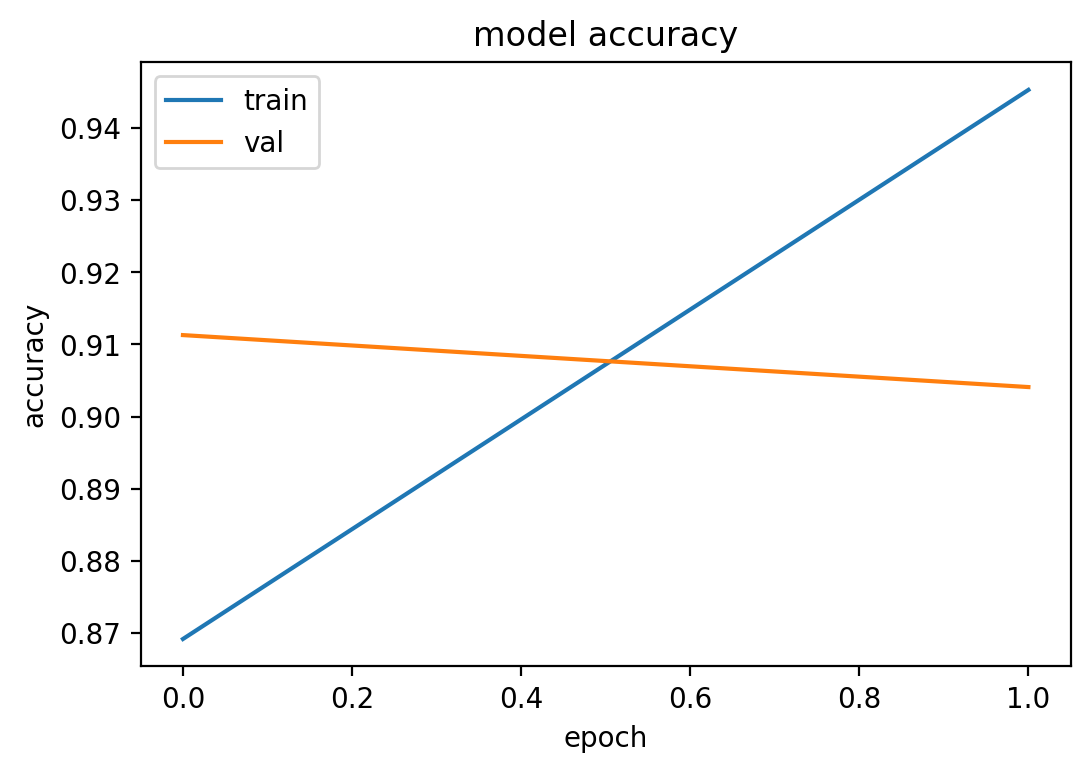

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

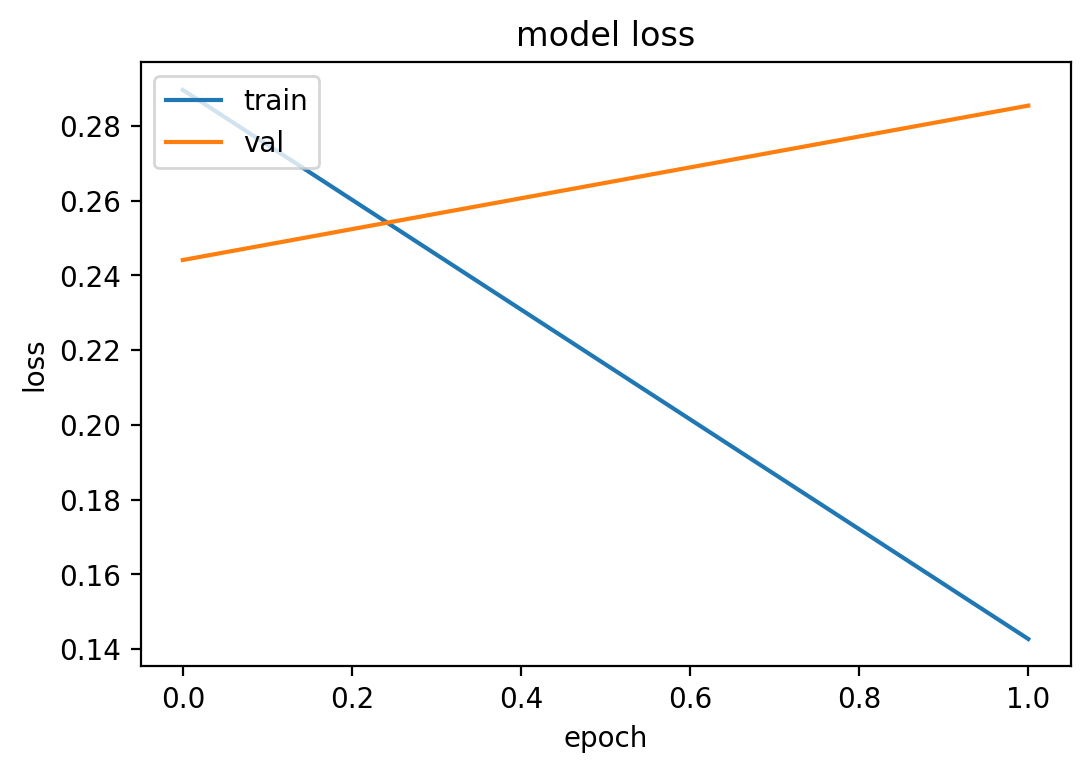

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
DBERT_model.evaluate(dict(X_test), y_test, batch_size = 100)

250/250 [==============================] - 462s 2s/step - loss: 0.2792 - accuracy: 0.9027


[0.2791915535926819, 0.902679979801178]

This is actually just a tiny bit better than our BERT model. The state-of-the art on the IMDB dataset is around 92.5%, so we're a smidge behind, but we did so with two of the "smaller" pre-trained transformer models, fine-tuned for only 2 epochs each.  